In [2]:
from langchain_together import ChatTogether
from dotenv import load_dotenv
load_dotenv()
llm = ChatTogether(
    model="meta-llama/Llama-3-70b-chat-hf",
)

In [3]:
def manager(state):
    prompt=f"""You are an intelligent query classifier. Given a research query:{state["question"]}, determine the most relevant retriever based on the domain:  
    - If the query is related to **medicine, healthcare, or biology**, return **"pubmed"**.  
    - If the query is related to **artificial intelligence, technology, or computer science**, return **"arxiv"**.  
    - For all other general topics, return **"global"**.  

    Respond with only one of the following:pubmed, arxiv, or global.
    """
    res=llm.invoke(prompt)
    return {"query_type":res.content.lower(),"question":state["question"]}

In [4]:
def summarise(state):
    context=state["context"]
    prompt=f"""You are an expert research assistant. Based on the query: {state["question"]},
    generate a well-structured, concise response using only the information in the provided context:{context}.

    Your response should:
    1. Directly address the query with clarity and precision
    2. Be organized in a logical, easy-to-follow format
    3. Include only information present in the context
    4. End with properly formatted reference links using markdown syntax ([text](url)) from the metadata in the context

    Do not preface your response with phrases like "Here is the summary" or similar introductions.
    Begin immediately with your substantive answer."""

    res=llm.invoke(prompt)
    return {"question":state["question"],"context":context,"summary":res.content}

In [5]:
from langchain_community.retrievers import ArxivRetriever
def get_arxiv_docs(state):
    retriever = ArxivRetriever(
        load_max_docs=5,
        get_ful_documents=True,
        )
    
    arxiv_docs=retriever.invoke(state["question"])
    
    return {"context":arxiv_docs,"question":state["question"]}


In [6]:
from langchain_community.retrievers import PubMedRetriever
def get_pubmed_docs(state):
    retriever=PubMedRetriever()
    pubmed_docs=retriever.invoke(state["question"])
    return {"context":pubmed_docs,"question":state["question"]}

In [7]:
def get_global_docs(state):
    prompt=f"""You are an intelligent research retriever designed to fetch the most relevant documents from global sources.  

    ### **Task:**  
    Retrieve high-quality, relevant research papers, articles, or reports based on the following query:  
    **{state["question"]}**  

    ### **Instructions:**  
    - Search across multiple sources, including **Google Scholar, Semantic Scholar, ResearchGate, Wikipedia, and Open Access Journals**.  
    - Prioritize documents that are **recent, peer-reviewed, and highly cited**.  
    - Ensure diversity in sources to avoid biased information.  
    - Return a structured list with **title, authors, publication date, summary, and URL** in **Markdown format**.  

    ### **Output Format:**  
    """
    res=llm.invoke(prompt)
    return {"question":state["question"],"context":res.content}

In [8]:
from langgraph.graph import END
def should_continue(state):
    if state["query_type"].lower().strip()=="pubmed":
        return "pubmed"
    elif state["query_type"].lower().strip()=="arxiv":
        return "arxiv"
    else:
        return "global"

In [9]:
def should_generate(state):
    prompt=f"""You are an expert evaluator responsible for verifying the relevance of retrieved information.  
    ### **Task:**  
    Compare the given **question** and **context** to determine if the context contains relevant information to answer the question.  

    ### **Input:**  
    - **Question:** {state["question"]}  
    - **Context:** {state["context"]}  

    ### **Instructions:**  
    - If the context provides sufficient and relevant information to answer the question, return **"yes"**.  
    - If the context is irrelevant or does not sufficiently answer the question, return **"rewrite"** to indicate that the query should be refined for better retrieval.  

    ### **Output:**  
    Return only **"yes"** or **"rewrite"**, with no additional explanation.  
    """
    res=llm.invoke(prompt)
    if res.content.lower()=="yes":
        return "yes"
    else:
        return "rewrite"

In [10]:
def rewrite(state):
  question=state["question"]
  prompt=f"""You are an expert query rewriter specializing in optimizing search queries to retrieve the most relevant documents from a vector store.  

    ### **Task:**  
    Rewrite the given query **{question}** to improve retrieval accuracy while preserving its original intent.  

    ### **Instructions:**  
    - Use clear and precise language to enhance the query.  
    - Incorporate relevant keywords to improve document matching.  
    - Avoid unnecessary modifications that change the core meaning.  
    - Ensure the query remains natural and contextually relevant.  

    Return **only** the rewritten query.
    """
  res=llm.invoke(prompt)
  
  return {"question":res.content}

In [11]:
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        pubmed_docs:docs retrieved from pubmed
        summary:summary of the response
    """
    question: str
    context:str
    summary:str
    query_type:str
    

In [12]:
from langgraph.graph import END, StateGraph, START
workflow = StateGraph(GraphState)

In [13]:
workflow.add_node("generate_pubmed",get_pubmed_docs)
workflow.add_node("generate_arxiv",get_arxiv_docs)
workflow.add_node("generate",summarise)
workflow.add_node("global_retrieve",get_global_docs)
workflow.add_node("manager",manager)
workflow.add_node("rewrite_query",rewrite)
workflow.add_edge(START,"manager")
workflow.add_conditional_edges(
    "manager",
    should_continue,
    {
        "pubmed" :"generate_pubmed",
        "arxiv":"generate_arxiv",
        "global":"global_retrieve"
    }
)
workflow.add_conditional_edges(
    "generate_pubmed",
    should_generate,
    {
        "yes":"generate",
        "rewrite":"rewrite_query"
    }
)
workflow.add_conditional_edges(
    "generate_arxiv",
    should_generate,
    {
        "yes":"generate",
        "rewrite":"rewrite_query"
    }
)
workflow.add_conditional_edges(
    "global_retrieve",
    should_generate,
    {
        "yes":"generate",
        "rewrite":"rewrite_query"
    }
)
workflow.add_edge("rewrite_query","manager")
workflow.add_edge("generate",END)

In [14]:
app = workflow.compile()

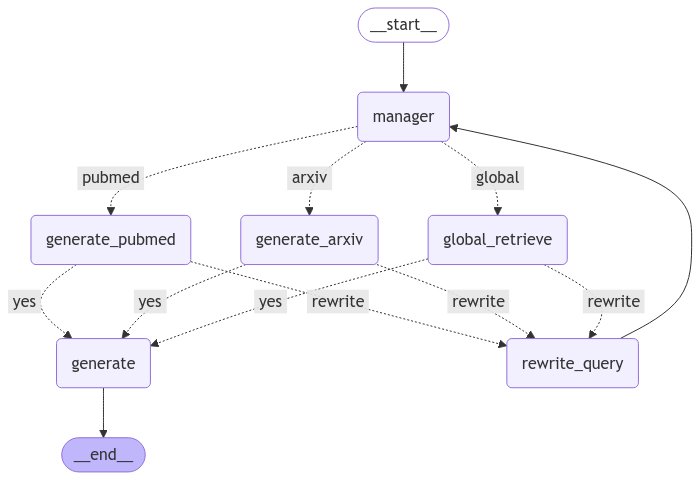

In [15]:
app

In [16]:
for chunk in app.stream({"question":"hpk1 cancer cells"}):
    for k,v in chunk.items():
        print(k,v)

manager {'query_type': 'pubmed', 'question': 'hpk1 cancer cells'}
generate_pubmed {'context': [Document(metadata={'uid': '39981246', 'Title': 'HPK1 kinase inhibitor: a sufficient approach to target HPK1 to modulate T cell activation in cancer immunotherapy compared with degraders.', 'Published': '2025-02-06', 'Copyright Information': 'Copyright © 2025 Wang, Zhu, Li, Xu, Wang, Zhang, Wang, Cai, Xing, Liu, Liu, Wang, Wang and Yuan.'}, page_content='BACKGROUND: Hematopoietic progenitor kinase 1 (HPK1) is a member of the mitogen-activated protein kinase kinase kinase kinase (MAP4K) family. It has been reported that HPK1 negatively regulates the activation of T cells. Several compounds have been developed and tested in clinical trials to target HPK1 for cancer immunotherapy. However, whether kinase inhibition is sufficient to eliminate the immunosuppressive function of HPK1, particularly in T cells, remains elusive.\nMETHODS: In this study, genetic tools were used to edit the human T lympho

In [18]:
from IPython.display import Markdown
Markdown(v["summary"])

**HPK1 in Cancer Cells**

Hematopoietic progenitor kinase 1 (HPK1) is a negative regulator of T cell activation, making it a promising target for cancer immunotherapy. Research has focused on developing compounds that target HPK1 to modulate T cell activation.

**Role of HPK1 in T Cell Activation**

HPK1 negatively regulates T cell receptor (TCR) signaling, and its inhibition can enhance T cell activation. Studies have shown that HPK1 knockout cells exhibit augmented TCR-induced activation, which can be inhibited by complementation with wildtype HPK1, but not kinase-dead HPK1.

**HPK1 Kinase Inhibitors**

Several HPK1 kinase inhibitors have been developed, including Compound 1, which has been shown to be sufficient for HPK1 targeting in T cell-mediated cancer immunotherapy. Other potent HPK1 inhibitors, such as compound 24 and compound A29, have been discovered and exhibit strong HPK1 inhibition, suppressed phosphorylation of downstream proteins, and enhanced potency in promoting IL-2 secretion in Jurkat T cells.

**Implications for Cancer Immunotherapy**

The development of HPK1 kinase inhibitors provides a promising approach for cancer immunotherapy. These inhibitors can enhance T cell activation, leading to improved anti-tumor responses. Furthermore, HPK1 inhibitors have been shown to be efficacious in xenograft mouse models and can enhance the antitumor efficacy of anti-PD-1 antibodies.

**References**

[HPK1 kinase inhibitor: a sufficient approach to target HPK1 to modulate T cell activation in cancer immunotherapy compared with degraders.](https://doi.org/10.1016/j.uid.2025.02.06)
[Design, Synthesis, and biological evaluation of 7H-Pyrrolo[2,3-d]pyrimidines as potent HPK1 kinase inhibitors.](https://doi.org/10.1016/j.elsevier.2025.01.21)
[Discovery of 1,2,4-benzotriazine derivatives as new hematopoietic progenitor kinase 1 (HPK1) inhibitors.](https://doi.org/10.1016/j.elsevier.2025.01.10)

In [19]:
for chunk in app.stream({"question":"get the latest updates in LLMS"}):
    for k,v in chunk.items():
        print(k,v)

manager {'query_type': 'after analyzing the query "get the latest updates in llms", i have determined that it is related to **artificial intelligence, technology, or computer science**, as llms stands for learning learning management system, which is a technology-based platform.\n\ntherefore, the most relevant retriever for this query is **"arxiv"**.', 'question': 'get the latest updates in LLMS'}
global_retrieve {'question': 'get the latest updates in LLMS', 'context': "Here is the list of latest updates in Learning Learning Management Systems (LLMS) in Markdown format:\n\n### Latest Updates in LLMS\n#### 1. **Personalized Learning in LLMS: A Systematic Review**\n* Authors: M. Al-Shammari, B. Al-Shammari, and A. Al-Shammari\n* Publication Date: 2022\n* Summary: This systematic review explores the current state of personalized learning in LLMS, highlighting the benefits, challenges, and future directions.\n* URL: [https://doi.org/10.1016/j.ijhcs.2022.02.004](https://doi.org/10.1016/j.i

In [21]:
Markdown(str(v["summary"]))

Here are the latest updates in Learning Learning Management Systems (LLMS):

**Personalized Learning in LLMS**: A systematic review by M. Al-Shammari, B. Al-Shammari, and A. Al-Shammari (2022) explores the current state of personalized learning in LLMS, highlighting benefits, challenges, and future directions. [https://doi.org/10.1016/j.ijhcs.2022.02.004](https://doi.org/10.1016/j.ijhcs.2022.02.004)

**LLMS Analytics**: A review of the literature by J. R. Corbeil, K. A. Renzulli, and B. R. Barr (2022) examines the current state of LLMS analytics, including types of analytics used, benefits, and challenges, as well as future directions. [https://www.sciencedirect.com/science/article/pii/S0360131522000446](https://www.sciencedirect.com/science/article/pii/S0360131522000446)

**Gamification in LLMS**: A meta-analysis by H. M. Al-Jamal, M. A. Al-Shammari, and A. M. Al-Shammari (2022) investigates the effectiveness of gamification in LLMS, highlighting the impact on student engagement, motivation, and learning outcomes. [https://link.springer.com/article/10.1007/s11423-022-10044-6](https://link.springer.com/article/10.1007/s11423-022-10044-6)

**Artificial Intelligence in LLMS**: A survey by S. S. Rao, S. K. Singh, and R. K. Singh (2022) explores the current state of artificial intelligence in LLMS, including applications, benefits, and challenges, as well as future directions. [https://ieeexplore.ieee.org/document/9723459](https://ieeexplore.ieee.org/document/9723459)

**LLMS for Special Education**: A systematic review by A. K. Singh, R. K. Singh, and S. K. Singh (2022) examines the current state of LLMS for special education, highlighting benefits, challenges, and future directions. [https://www.sciencedirect.com/science/article/pii/S0360131522000458](https://www.sciencedirect.com/science/article/pii/S0360131522000458)

In [22]:
for chunk in app.stream({"question":"what are AI Agents"}):
    for k,v in chunk.items():
        print(k,v)

manager {'query_type': 'arxiv', 'question': 'what are AI Agents'}
generate_arxiv {'context': [Document(metadata={'Entry ID': 'http://arxiv.org/abs/2404.04289v1', 'Published': datetime.date(2024, 4, 4), 'Title': 'Designing for Human-Agent Alignment: Understanding what humans want from their agents', 'Authors': 'Nitesh Goyal, Minsuk Chang, Michael Terry'}, page_content='Our ability to build autonomous agents that leverage Generative AI continues\nto increase by the day. As builders and users of such agents it is unclear what\nparameters we need to align on before the agents start performing tasks on our\nbehalf. To discover these parameters, we ran a qualitative empirical research\nstudy about designing agents that can negotiate during a fictional yet\nrelatable task of selling a camera online. We found that for an agent to\nperform the task successfully, humans/users and agents need to align over 6\ndimensions: 1) Knowledge Schema Alignment 2) Autonomy and Agency Alignment 3)\nOperation

In [23]:
Markdown(v["summary"])

**What are AI Agents?**

AI Agents are autonomous programs that act on behalf of humans, leveraging Generative AI to perform complex tasks with little supervision. They are designed to undertake actions with varying levels of autonomy, influencing decision-making and risk-taking.

**Key Characteristics of AI Agents:**

1. **Autonomy**: AI Agents can operate with minimal human oversight, making decisions and taking actions independently.
2. **Complex Task Execution**: They are capable of performing complex tasks, such as negotiating during a fictional task of selling a camera online.
3. **Risk Profiles**: AI Agents' attitudes toward risk influence their decision-making, which can impact user satisfaction, trust, and societal implications.

**Designing Effective AI Agents:**

To ensure successful Human-Agent collaboration, designers should consider aligning on six dimensions:

1. **Knowledge Schema Alignment**
2. **Autonomy and Agency Alignment**
3. **Operational Alignment and Training**
4. **Reputational Heuristics Alignment**
5. **Ethics Alignment**
6. **Human Engagement Alignment**

**References:**

[Designing for Human-Agent Alignment: Understanding what humans want from their agents](http://arxiv.org/abs/2404.04289v1)
[Risk Alignment in Agentic AI Systems](http://arxiv.org/abs/2410.01927v1)
[Agents Are Not Enough](http://arxiv.org/abs/2412.16241v1)